In [1]:
import argparse
import torch
from src import utils as ut
from src.models.vaer import VAER
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
device = 'cpu'

comps_selection_metrics_dim=166
regression_metrics_dim=19
gen_weight=1
regressor_weight=100
nn='reg_only'

train_set_df, val_set_df, test_set_df = ut.get_train_val_test_datasets()

In [9]:
def validate_mse(data_set_df, from_epoch, to_epoch, step_epoch):
    val_no_title_df = data_set_df.drop(['title_lower'], axis=1)
    X = val_no_title_df.iloc[:, :-1]
    y = val_no_title_df.iloc[:, -1:]
    vaer = VAER(comps_selection_metrics_dim=comps_selection_metrics_dim, regression_metrics_dim=regression_metrics_dim, nn=nn, gen_weight=gen_weight, regressor_weight=regressor_weight).to(device)
    vaer.eval()
    for i in range(from_epoch, to_epoch, step_epoch):
        file_path = os.path.join('checkpoints',
                                 '{}'.format(vaer.nn),
                                 'model-{:05d}.pt'.format(i))
        state = torch.load(file_path, map_location=device)
        vaer.load_state_dict(state)
        y_hat, reg_mse, z_m, z_v  = vaer.validate_reg_output(torch.tensor(X.values).float().to(device), torch.tensor(y.values).float().to(device))
        print(i, reg_mse.mean())
        
def prepare_plot(epoch, title):
    vaer = VAER(comps_selection_metrics_dim=comps_selection_metrics_dim, regression_metrics_dim=regression_metrics_dim, nn=nn, gen_weight=gen_weight, regressor_weight=regressor_weight).to(device)
    vaer.eval()
    file_path = os.path.join('checkpoints',
                             '{}'.format(vaer.nn),
                             'model-{:05d}.pt'.format(epoch))
    state = torch.load(file_path, map_location=device)
    vaer.load_state_dict(state)
    title_df = test_set_df[test_set_df['title_lower'] == title]
    title_df = title_df.drop(['title_lower'], axis=1)
    X = title_df.iloc[:, :-1]
    y = title_df.iloc[:, -1:]
    y_logits, reg_mse, z_m, z_v = vaer.validate_reg_output(torch.tensor(X.values).float().to(device), torch.tensor(y.values).float().to(device))
    print('mse: ', reg_mse.mean())
    y_hat = pd.DataFrame(y_logits.cpu().detach().numpy())
    weeknum = X[['1/weeknum']]
    y_hat.reset_index(drop=True, inplace=True)
    weeknum.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
    # Place the DataFrames side by side
    df = pd.concat([weeknum, y, y_hat], ignore_index=True, axis=1)
    df = df.rename(columns = {0: "1/weeknum", 1:"units_actual", 2: "units_predicted"}) 
    df['weeknum'] = df.apply (lambda row: 1.0/row['1/weeknum'], axis=1)
    
    return df

def plot(df, title):
    # gca stands for 'get current axis'
    ax = plt.gca()

    df.plot(kind='line',x='weeknum',y='units_actual', color='blue', ax=ax)
    df.plot(kind='line',x='weeknum',y='units_predicted', color='orange', ax=ax)
    plt.title(title)
    plt.show()

In [ ]:
validate_mse(val_set_df, 50,1001,50)

In [10]:
validate_mse(test_set_df, 200,201,10)

200 tensor(0.7015, grad_fn=<MeanBackward0>)


mse:  tensor(0.0780, grad_fn=<MeanBackward0>)


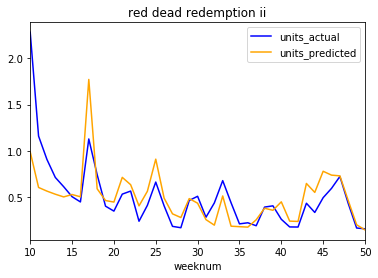

In [18]:
plot(prepare_plot(200, 'red dead redemption ii'), 'red dead redemption ii')

mse:  tensor(0.6172, grad_fn=<MeanBackward0>)


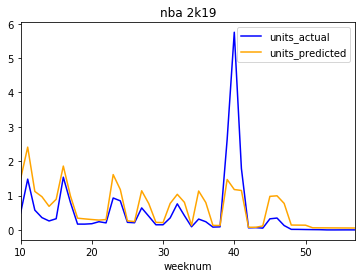

In [19]:
plot(prepare_plot(200, 'nba 2k19'), 'nba 2k19')

mse:  tensor(0.0484, grad_fn=<MeanBackward0>)


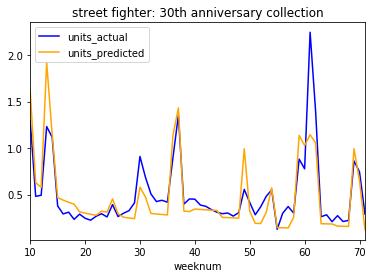

In [20]:
plot(prepare_plot(200, 'street fighter: 30th anniversary collection'), 'street fighter: 30th anniversary collection')

mse:  tensor(0.3687, grad_fn=<MeanBackward0>)


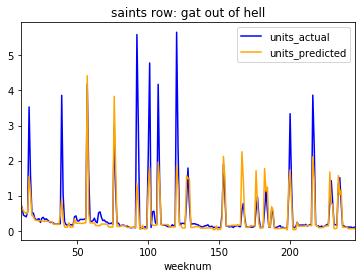

In [7]:
plot(prepare_plot(200, 'saints row: gat out of hell'), 'saints row: gat out of hell')

mse:  tensor(0.1595, grad_fn=<MeanBackward0>)


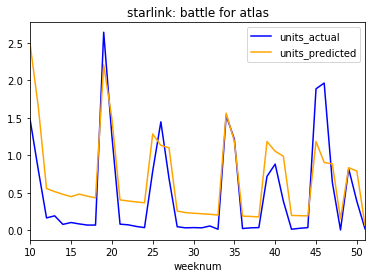

In [5]:
plot(prepare_plot(200, 'starlink: battle for atlas'), 'starlink: battle for atlas')

mse:  tensor(0.3378, grad_fn=<MeanBackward0>)


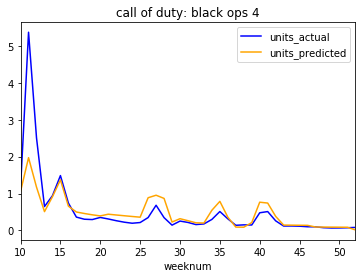

In [6]:
plot(prepare_plot(200, 'call of duty: black ops 4'), 'call of duty: black ops 4')